# [Computational Social Science] 
## 3-3 Tree-Based Ensemble Methods - Solutions

In this lab, we will explore extensions of decision trees. Particularly, we will introduce ensemble machine learning. This  which involves combining several machine learning algorithms together to create a better model.

## Virtual Environment
Remember to always activate your virtual environment first before you install packages or run a notebook! This helps to prevent conflicts between dependencies across different projects and ensures that you are using the correct versions of packages. You must have created anaconda virtual enviornment in the `Anaconda Installation` lab. If you have not or want to create a new virtual environment, follow the instruction in the `Anaconda Installation` lab. 

<br>

If you have already created a virtual enviornment, you can run the following command to activate it: 

<br>

`conda activate <virtual_env_name>`

<br>

For example, if your virtual environment was named as CSS, run the following command. 

<br>

`conda activate CSS`

<br>

To deactivate your virtual environment after you are done working with the lab, run the following command. 

<br>

`conda deactivate`

<br>

## Data

We're going to use our [Census Income dataset](https://archive.ics.uci.edu/dataset/20/census+income) again for this lab. Let's load the dataset.

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

%matplotlib inline
#sns.set_style("darkgrid")

In [2]:
# Create a list of column names, found in "adult.names"
# ----------
col_names = ['age', 
             'workclass', 
             'fnlwgt',
             'education', 
             'education-num',
             'marital-status', 
             'occupation', 
             'relationship', 
             'race', 
             'sex', 
             'capital-gain',
             'capital-loss', 
             'hours-per-week',
             'native-country', 
             'income-bracket']

# Read table from the data folder
census = pd.read_table("../../data/adult.data", 
                       sep = ',', 
                       names = col_names)
census.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Remember, we need to preprocess the data to binarize the target and dummify our categorical features.

In [4]:
# Target
# ----------
lb = LabelBinarizer()
y = census['income-bracket-binary'] = lb.fit_transform(census["income-bracket"])

# Features
# ----------
X = census.drop(['income-bracket', 'fnlwgt', 'income-bracket-binary'], axis = 1)
X = pd.get_dummies(X)
X.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13,2174,0,40,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,13,0,0,13,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,9,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
3,53,7,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,28,13,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


## Decision Tree Classifier

The first model we will look at is the decision tree. Using the [`tree.DecisionTreeClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) method, let's implement a cross-validation approach to predicting income. We will initialize the model with the standard configurations from the Classification lab.

In [7]:
# Initialize a Decision Tree Classifier
# ----------
dt_classifier = tree.DecisionTreeClassifier(
                       criterion='gini',              # or 'entropy' for information gain
                       splitter='best',               # or 'random' for random best split
                       max_depth=None,                # set how deep tree nodes can go
                       min_samples_split=2,           # samples needed to split node
                       min_samples_leaf=1,            # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,             # number of features to look for when splitting
                       max_leaf_nodes=None,           # max nodes
                       min_impurity_decrease=1e-07,   # early stopping
                       random_state = 10)             #random seed

In [8]:
# cross_val_score returns the accuracy score by default but you can change this with the "scoring" argument
scores = cross_val_score(dt_classifier,   # specify estimator 
                         X,               # specify X
                         y,               # specify y
                         cv=5)            # number of cross validation 

In [9]:
# view the scores individually
scores

array([0.82189467, 0.82048526, 0.81557125, 0.82125307, 0.82202088])

In [14]:
# take the mean score from the results of cross validation
scores.mean()

0.8202450278049079

.82 accuracy, not bad! We can also visualize the decision tree to see how it made its splits. Note we limit the max depth to 4 so that the code runs quickly, but in practice you might want to visualize the entire tree.

In [16]:
# calculate the length of our feature dataframe to be able to judge splits by # of observations
len(X)

32561

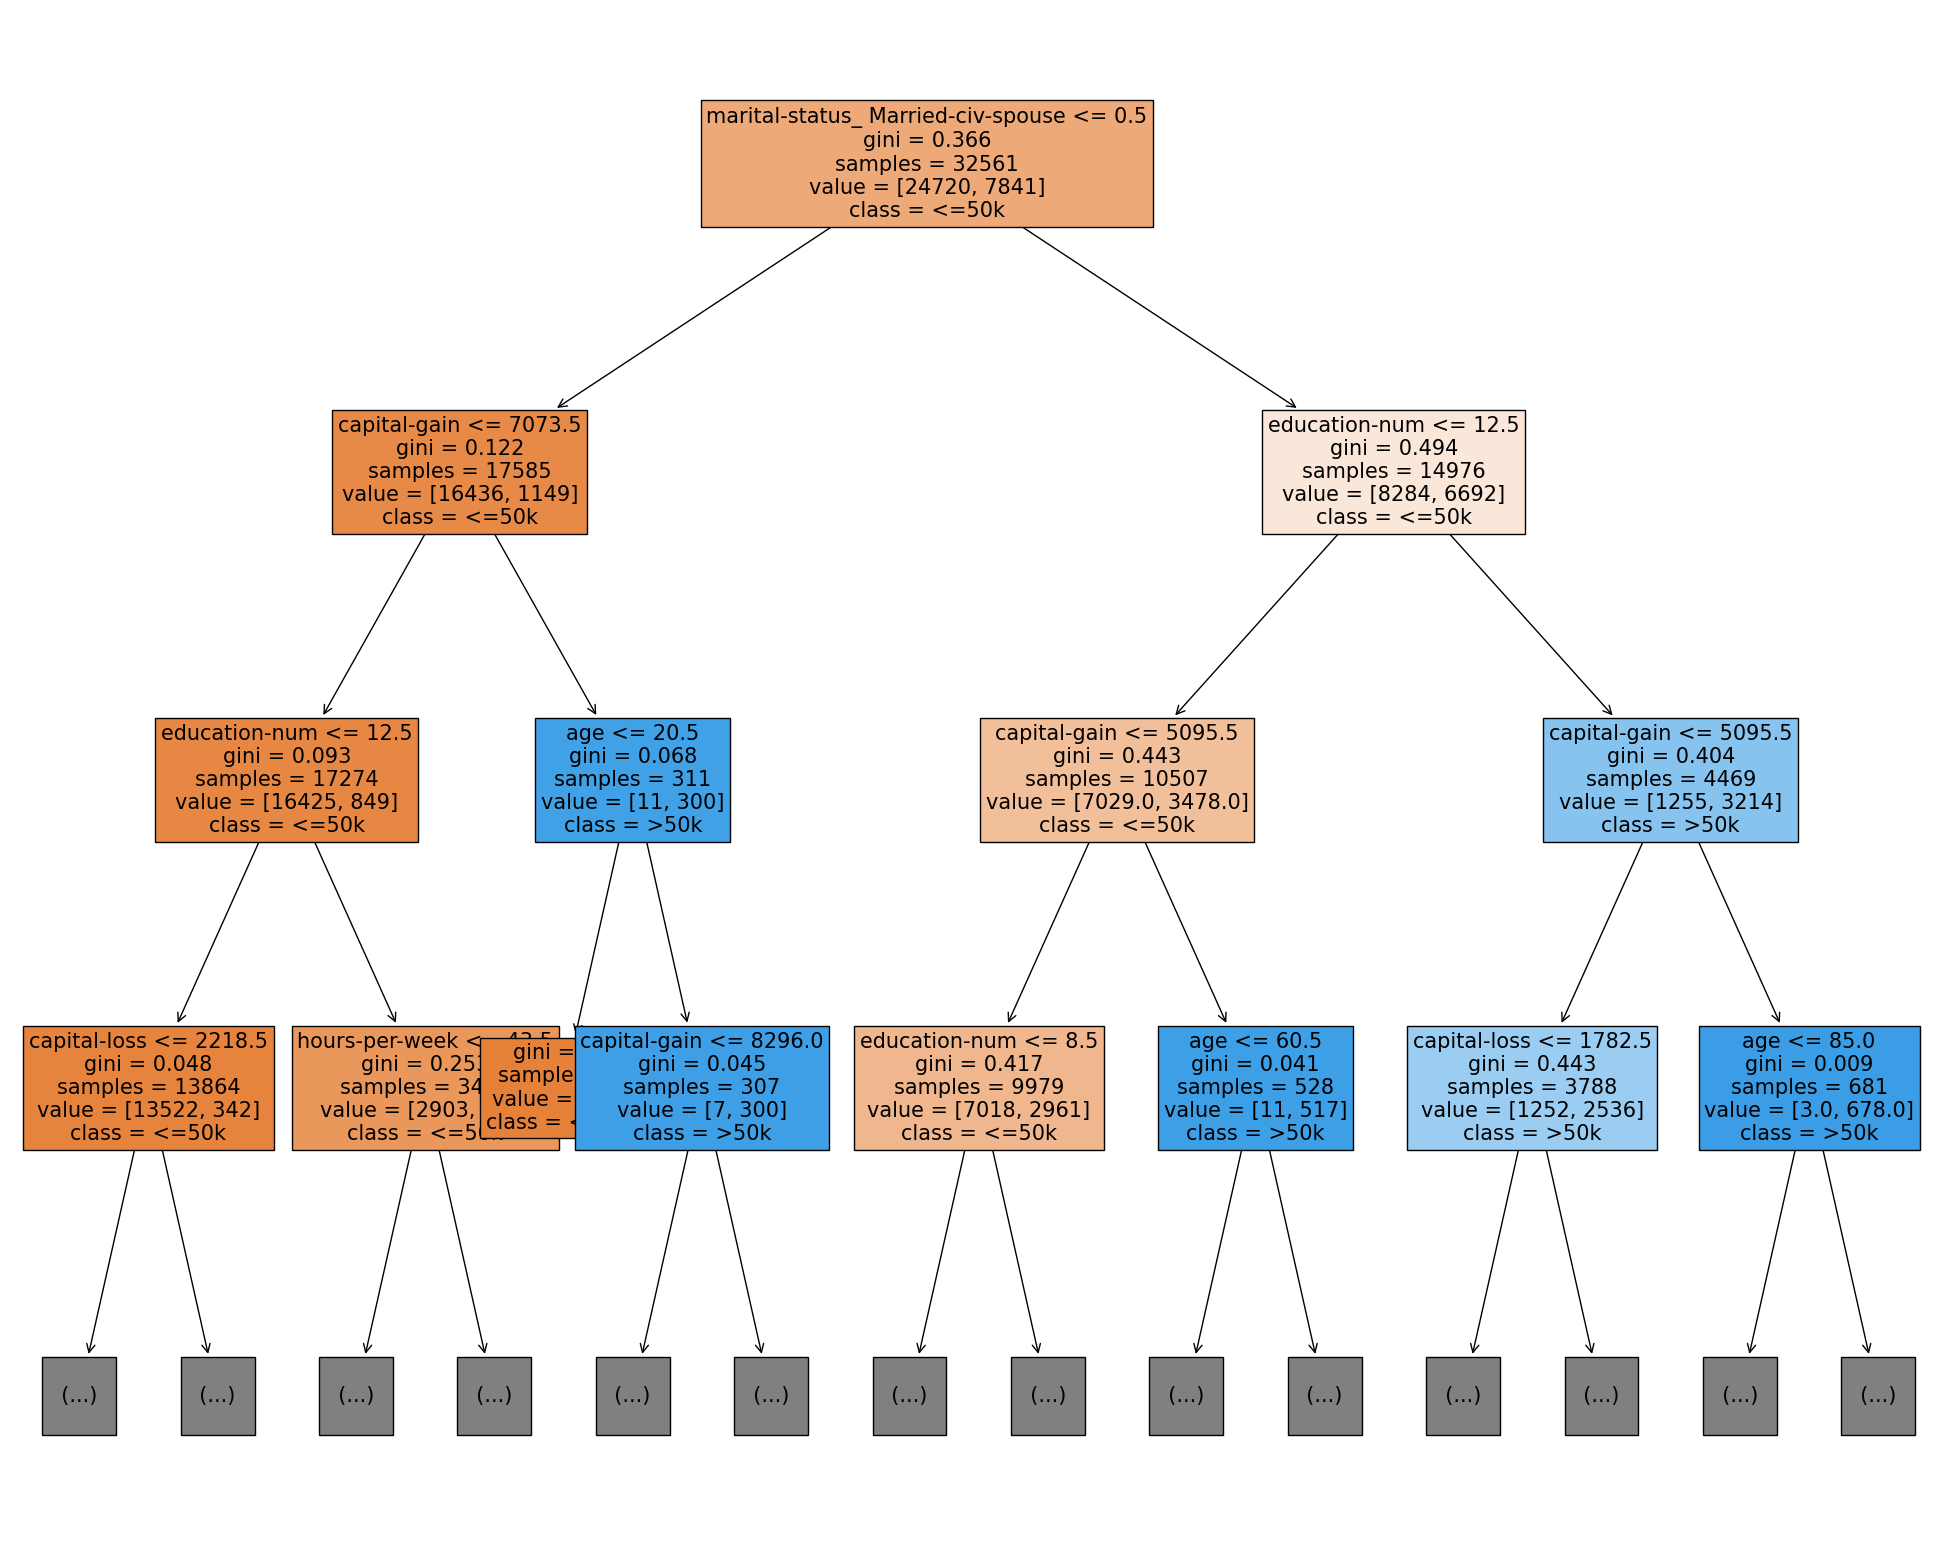

In [17]:
# fit to data
# ----------
dt_classifier.fit(X, y)

# set column names as list
# ----------
column_names = X.columns.tolist()

# plot the figure
# ----------
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_classifier, 
                   feature_names=column_names,      # make sure its a list
                   class_names=["<=50k", ">50k"],   # specify class names
                   filled=True,                     # paint nodes to indicate majority class 
                   fontsize = 15,                   # set fontsize
                   max_depth = 3)                   # set max depth of tree to view

In [18]:
# we can use the .max_depth attribute to check out the depth of our entire tree
dt_classifier.tree_.max_depth

52

In [23]:
# remind ourselves how many samples in our negative class
np.count_nonzero(y==0)

24720

In [24]:
# check the samples after root node
X['marital-status_ Married-civ-spouse'].value_counts()

marital-status_ Married-civ-spouse
False    17585
True     14976
Name: count, dtype: int64

In [25]:
# identify the most informative features
# ----------
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(dt_classifier.feature_importances_,3)})
importances = importances.sort_values('importance',
                                      ascending=False)
importances

,feature,importance
32,marital-status_ Married-civ-spouse,0.214
0,age,0.161
1,education-num,0.125
2,capital-gain,0.120
4,hours-per-week,0.100
...,...,...
78,native-country_ Guatemala,0.000
79,native-country_ Haiti,0.000
80,native-country_ Holand-Netherlands,0.000
81,native-country_ Honduras,0.000


# Ensemble Learning
Ensemble learning is a machine learning paradigm where multiple learners (also known as base or individual models) are trained to solve the same problem. The main idea behind ensemble learning is that a group of "weak learners" can come together to form a "strong learner". Each weak learner makes a prediction, and then the ensemble model makes its final prediction based on the votes or the outputs of all the weak learners.

Ensemble learning often significantly improves machine learning results by combining several models. This approach allows the production of better predictive performance compared to a single model.

## Random Forest

Next, we'll take a look at the [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Random Forest is an extension of the decision tree method. Rather than construct just one tree, a random forest grows many trees, using a subset of features to grow each tree. The trees then make predictions, and the random forest takes a majority vote from the trees to determine the winner. Random forest is known as a ["bagging"](https://en.wikipedia.org/wiki/Bootstrap_aggregating) method. Fill in the code below to train a random forest using cross-validation.

In [33]:
# initialize a random forest classifier
# ----------
rf_classifier = RandomForestClassifier(
                       # specify parameters
                       n_estimators=100,              # specify the number of trees (100 is default)
                       criterion='gini',              # or you can use 'entropy' for information gain
                       max_depth=None,                # how deep tree nodes can go
                       min_samples_split=2,           # samples needed to split node
                       min_samples_leaf=1,            # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,             # number of features to look for when splitting
                       max_leaf_nodes=None,           # max nodes
                       min_impurity_decrease=1e-07,   # early stopping
                       random_state = 10)             # random seed

In [35]:
# specify cross-validation
# ----------
scores = cross_val_score(rf_classifier, 
                         X, 
                         y.ravel(), # Some algorithms will expect you to ravel the target
                         cv=5)

In [36]:
# calculate the average score across models
# ----------
scores.mean()

0.8465649734362308

Although it is difficult to visualize a forest of trees, we *can* still visualize the feature importances. Use the code below to look at the top 10 most important features. 

**QUESTION:** What do you notice? Do you think we actually need a large feature space?

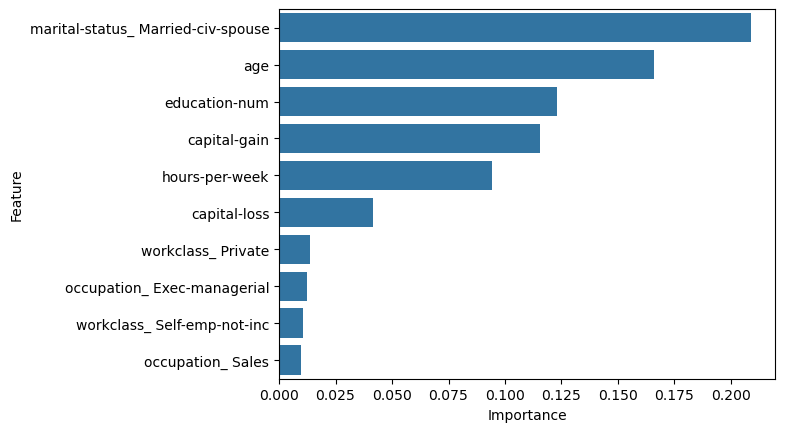

In [38]:
# fit the random forest on data to get feature importance
# ----------
rf_classifier.fit(X, y.ravel())

# import library
import seaborn as sns

# create feature importance dataframe
feat_importances = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(rf_classifier.feature_importances_))], axis = 1)
feat_importances.columns = ["Feature", "Importance"]

# plot 
sns.barplot(x = "Importance", 
            y = "Feature", 
            data = feat_importances.nlargest(10, 'Importance')) # identify the 10 most important features
plt.show()

**ANSWER:** Prob not, since it seems that only a handful of predictors are making important contributions to splitting the data (reducing impurity). 

We see that only a handful of features are contributing a lot to the model. We could probably simplify the decisionmaking considerably. Try training a new decision tree with max depth 5 and only use the 10 most important features.

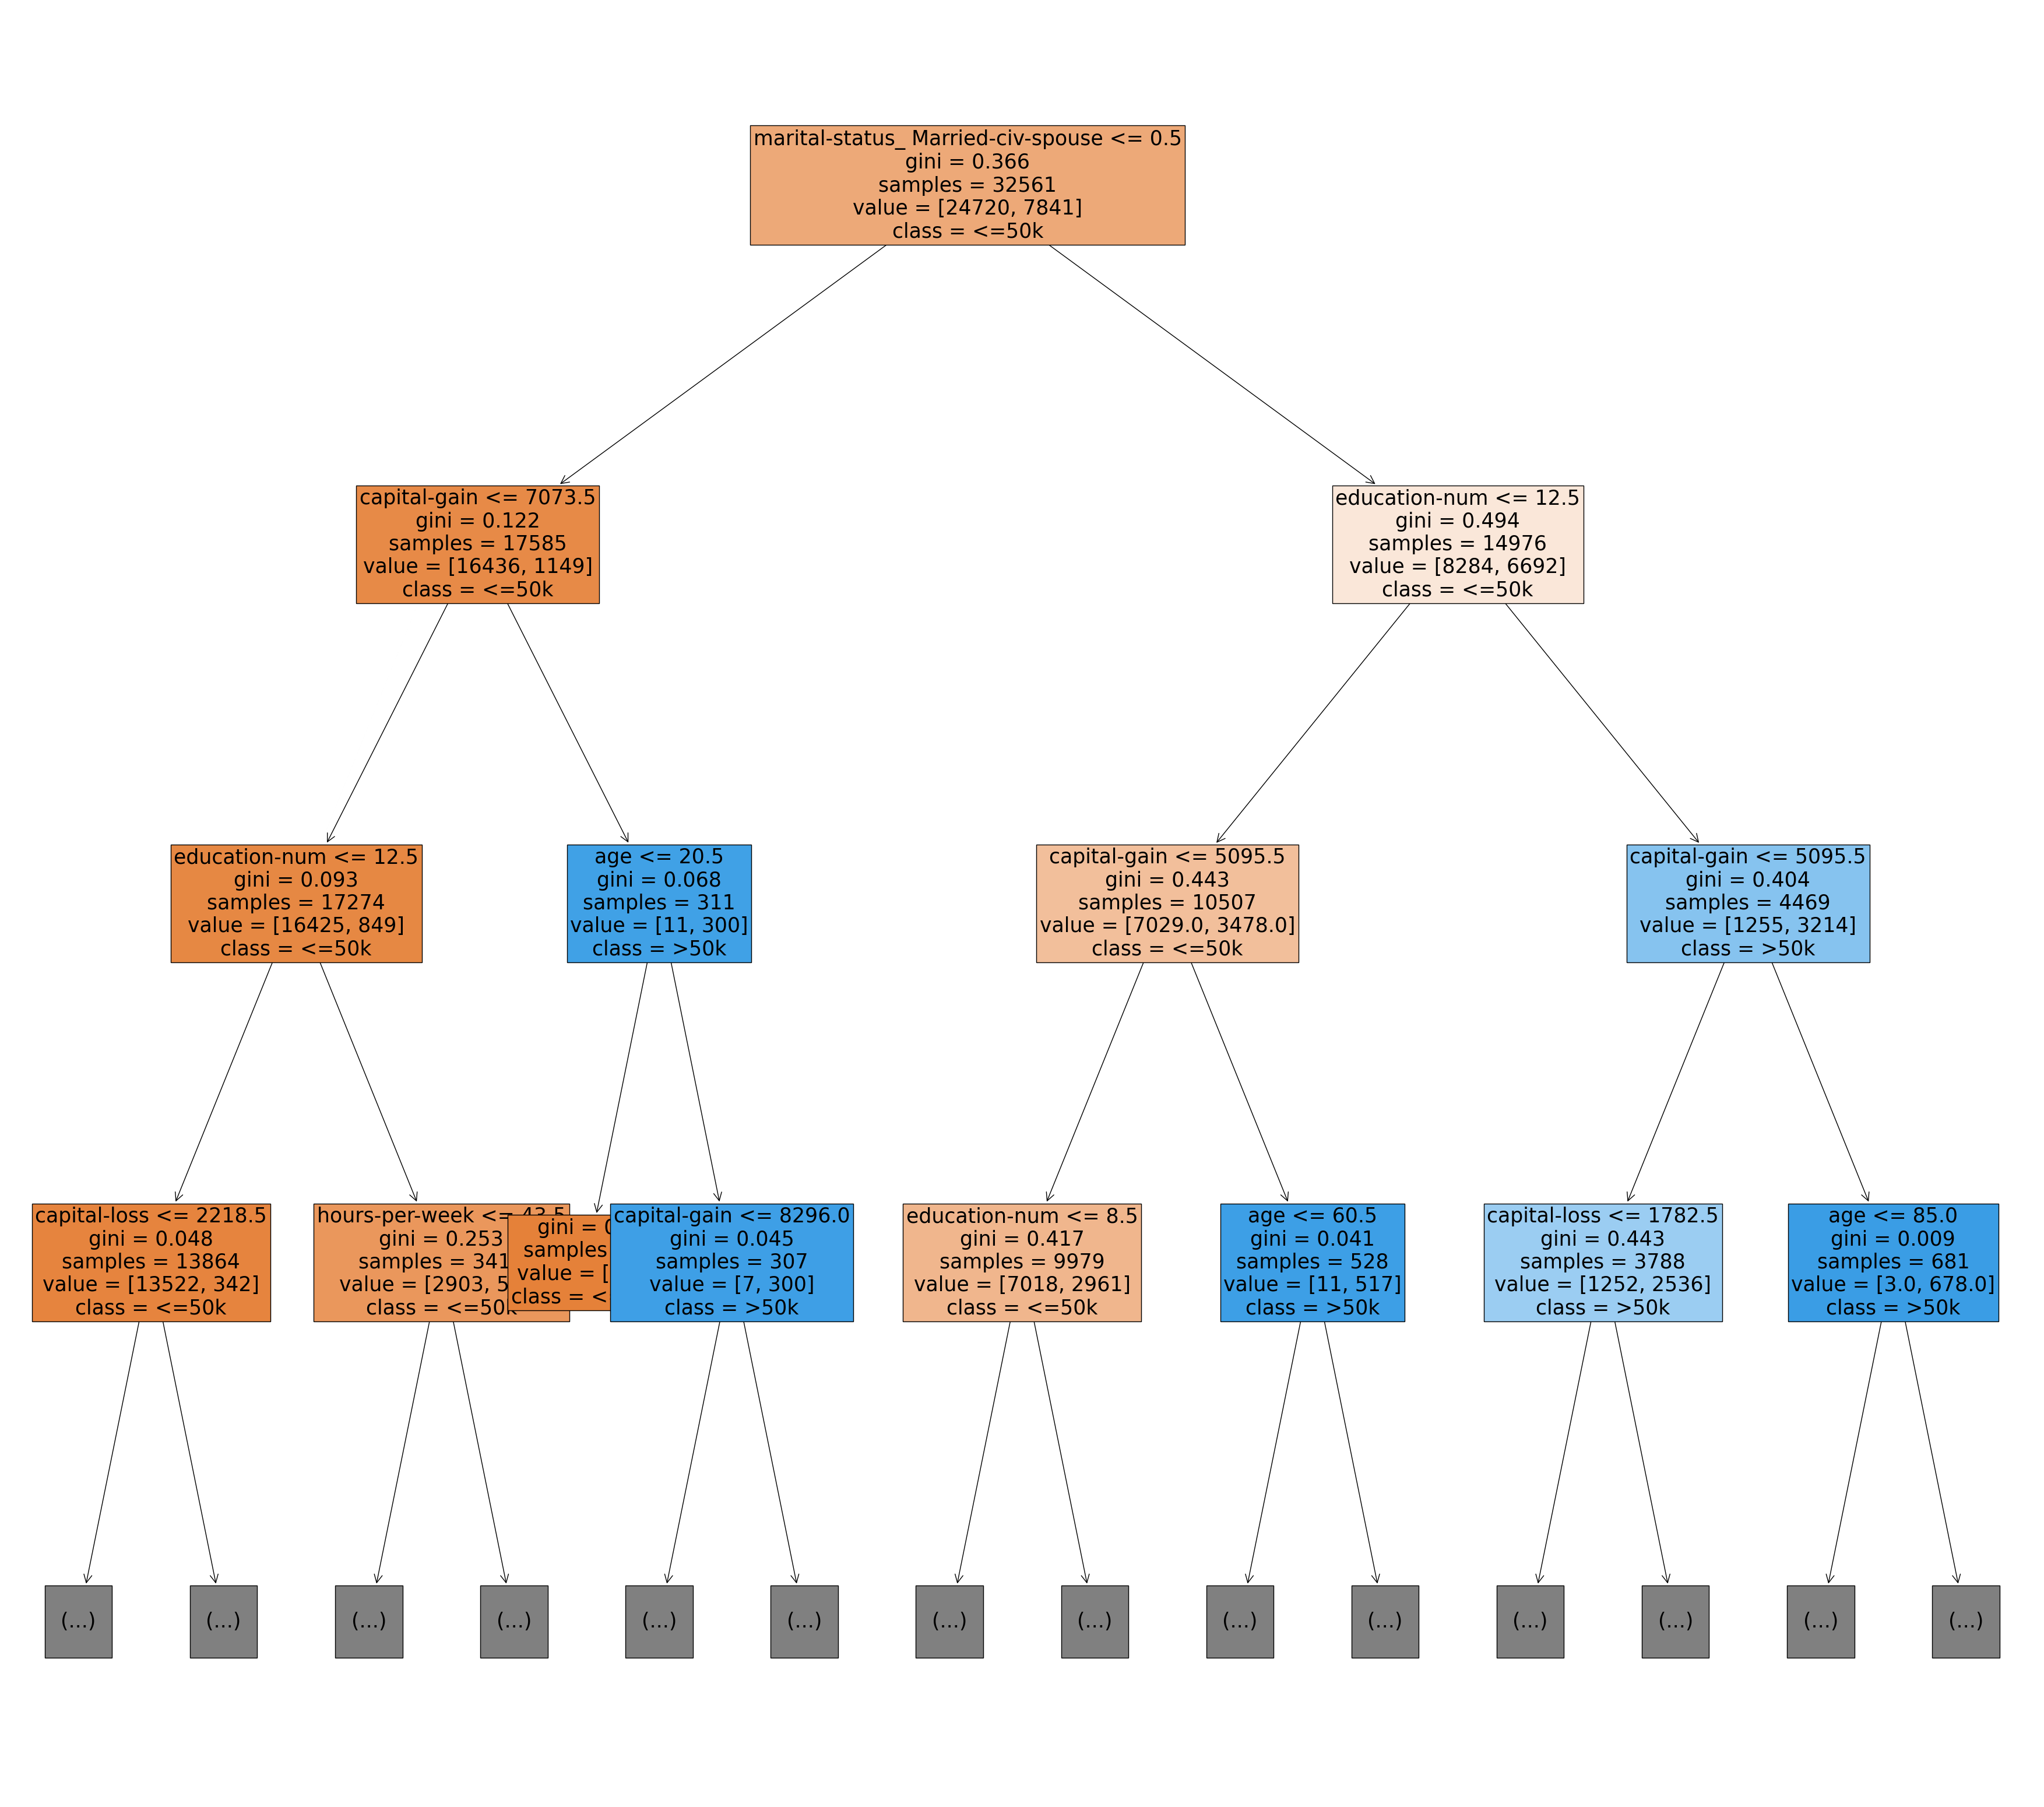

In [41]:
# refit a basic decision tree using reduced number of features 
# ----------
dt_reduced_classifier = tree.DecisionTreeClassifier(
                                 # specify parameters
                                 criterion='gini',              # or 'entropy' for information gain
                                 splitter='best',               # or 'random' for random best split
                                 max_depth=5,                   # how deep tree nodes can go
                                 min_samples_split=2,           # samples needed to split node
                                 min_samples_leaf=1,            # samples needed for a leaf
                                 min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                                 max_features=None,             # number of features to look for when splitting
                                 max_leaf_nodes=None,           # max nodes
                                 min_impurity_decrease=1e-07,   # early stopping
                                 random_state = 10)             # random seed

# pull out the most features
important_features = feat_importances.nlargest(10, 'Importance')['Feature']

# create new dataset with only most important features
X_reduced = X[X.columns[X.columns.isin(important_features)]]

# fit the model on the new reduced model
dt_reduced_classifier.fit(X_reduced,
                          y)

# set column names as list
reduced_column_names = X_reduced.columns.tolist()

# plot 
fig = plt.figure(figsize=(45,40))
_ = tree.plot_tree(decision_tree = dt_reduced_classifier,                          
                   feature_names=reduced_column_names,  # make sure its a list
                   class_names=["<=50k", ">50k"],       # specify class names
                   filled=True,                         # paint nodes to indicate majority class 
                   fontsize = 25,                       # set fontsize
                   max_depth = 3)                       # set max depth of tree to view                      

In [42]:
# check the samples after root node
# ----------
X['marital-status_ Married-civ-spouse'].value_counts()

marital-status_ Married-civ-spouse
False    17585
True     14976
Name: count, dtype: int64

Looks a lot more interpretable than a random forest! How did we do on accuracy?

In [44]:
# calculate accuracy using cross validation
# ----------
scores = cross_val_score(dt_reduced_classifier, 
                         X, 
                         y.ravel(),
                         cv=5)

# find the mean score across models
scores.mean()

0.8478856971371942

Almost .85! Slightly better then the whole random forest and better than our original decision tree. Growing a random forest and then simplifying down to a more basic decision tree is the basic procedure recommended by the [select-regress-round](https://arxiv.org/pdf/1702.04690.pdf) framework.

**Question**: Why did a simplified decision tree get better accuracy than the first one we ran?

**Answer**: The original decision tree probably had very high variance and was too complex. A simplified tree that is pruned to a depth of 5 and only uses a few features likely generalizes better.

## Adaptive Boosting

The other approach for ensembling decision trees is called ["boosting"](https://en.wikipedia.org/wiki/Boosting_(machine_learning). Whereas random forests grow many decision trees in parallel and take a vote from them, boosting algorithms start with a strong classifier and iterate on it with weak learners. The weak learners are trained on the errors, which makes boosting algorithms well suited for making classifications in difficult cases. Try filling in the code below to train an [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html).

In [52]:
# initialize an adaptive boosting classifer 
# ----------
ada_classifier = AdaBoostClassifier(n_estimators=100)

In [54]:
# calculate accuracy using cross validation
# ----------
scores = cross_val_score(ada_classifier,  # specify classifier
                         X,               # specify features
                         y.ravel(),       # specify labels
                         cv = 5)          # specify 5-fold cross validation

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

**QUESTION:** How does adaptive boosting compare to the random forest, the reduced feature tree, and the basic tree?

In [55]:
# calculate mean score across models 
# ----------
scores.mean()

0.8646541447439651

**ANSWER:** It does a little better than the previous models because it iteratively (sequentially) focuses on where previous models have done poorly and focuses on improvement there. 

**QUESTION:** What are some pros and cons of AdaBoost?

**ANSWER:** AdaBoost has improved prediction to random forests but it is also more prone to overfitting precisely because of how it gets better results (focuses on error). 

Here is a [link to a tutorial](https://medium.com/@chaudhurysrijani/tuning-of-adaboost-with-computational-complexity-8727d01a9d20) on `AdaBoost()` that uses a data visualization workflow (box-plots) to visually compare model accuracy of different hyperparameters. This particular workflow relies on user-written functions to create the dataframes necessary for visualization. 

So, while it is not is not as code-efficient as using GridSearchCV(), it could be helpful in understand model accuracy differences across a particualr hyperparameter and could be a workflow you might want to use to illustrate a point in a paper. 

# XGBoost


[XGBoost](https://xgboost.readthedocs.io/en/stable/) also uses sequential weak learners to train the models instead of creating a random forest. 

One key difference from `AdaBoost()` is that it uses Gradient Descent to minimize a loss function and improve fit whereas `AdaBoost()` assigns larger weights to incorrectly classified observations so that future models focus on classifying those observations in future models. 

Here is a [helpful explainer](https://medium.com/@thedatabeast/adaboost-gradient-boosting-xg-boost-similarities-differences-516874d644c6#:~:text=AdaBoost%20is%20generally%20slower%20than,explicit%20imputation%20of%20missing%20values.) the similarities and differences between these models.

In [24]:
# you will likely have to install xgboost using the command-line prompt below
# !pip install xgboost
import xgboost as xgb

**QUESTION:** How does XGBoost compare to the previous tree models?

In [25]:
# initialize an XGBoost classifier
# ----------
xgb_classifier = xgb.XGBClassifier(random_state=10)


# define the scoring metrics
scoring = {
          'accuracy': make_scorer(accuracy_score),
          'recall': make_scorer(recall_score),
          'precision': make_scorer(precision_score),
          'f1': make_scorer(f1_score)
          }


# perform cross-validation with 5-fold and return the trained estimators
cv_results = cross_validate(xgb_classifier,        # specify estimator 
                            X,                     # specify features
                            y.ravel(),             # specify outcome, and use ravel
                            cv=5,                  # specify 5-fold cross validation
                            return_estimator=True, # return the estimators fitted at each split
                            scoring=scoring)       # which scoring metrics to return (the whole list in this case)
 
# print the results for accuracy, recall, precision, and F1 score
for metric in ['test_accuracy', 'test_recall', 'test_precision', 'test_f1']:
    scores = cv_results[metric]
    print(f"{metric[5:]}: {scores.mean():.3f}")



accuracy: 0.873
recall: 0.661
precision: 0.779
f1: 0.715


**ANSWER:** XGBoost does even better (on accuracy at least) than any of the previous models, in part because it a combination of the best aspects of each of the other models.

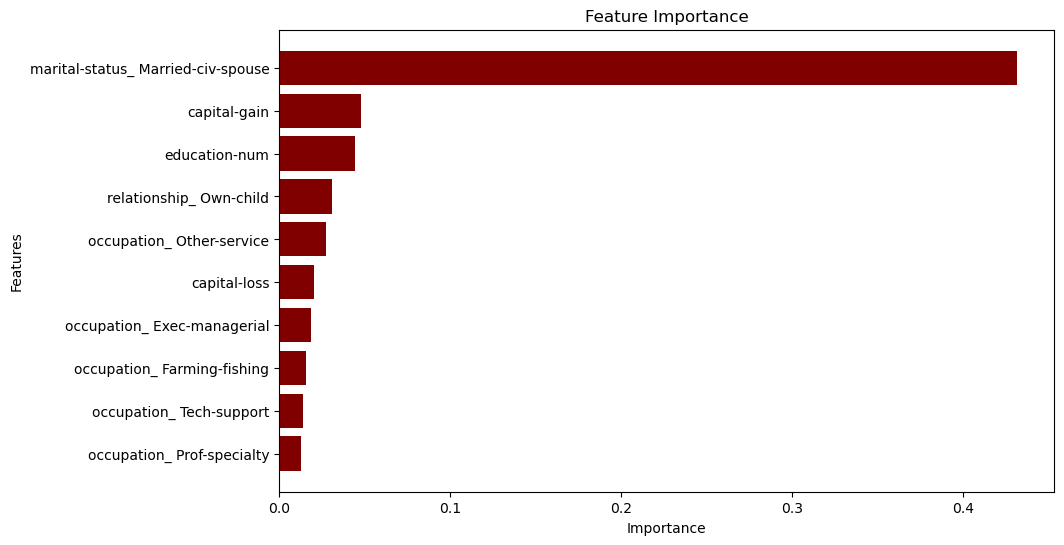

In [26]:
# Let's look at the feature importance
# ----------

# Initialize an array to hold the feature importances
importances = np.zeros(X.shape[1])

# Average the feature importances over the folds
for estimator in cv_results['estimator']:
    importances += estimator.feature_importances_
    
# Divide by the number of folds
importances /= 5  

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'feature': X.columns, 
                                   'importance': importances})

# Sort the features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Take the top 10 features
feature_importance = feature_importance.head(10)

# Plot the feature importances
plt.figure(figsize=(10, 6))

# horizontal bar plot
plt.barh(feature_importance['feature'], 
         feature_importance['importance'], 
         color='maroon', 
         align='center')

# labels
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')

# gca stands for "get current axis", which allows you to modify the properties of the axes.
# and then inverts the y-axis, meaning that the values that were at the bottom will now be at the top, and vice versa.
plt.gca().invert_yaxis() 
plt.show()

## Ensemble Learning Beyond Trees

You can also create ensembles with algorithms beyond decision trees. Scikit's ensemble module contains several different options for training ensemble models. Here, we will focus on the [`VotingClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) method. A voting classifier works in a similar fashion to random forest. However, **instead of taking a majority vote of decision trees, it takes a majority vote of various algorithms.** 

The voting can be **"hard"** which means the ensemble uses a majority vote of predicted classes, or **"soft"** meaning the votes are weighted by the probability associated with the prediction. 

Run the code below to initialize a logistic regression, a random forest, and an adaboost model. Pass all three of these into the VotingClassifier to train an ensemble model, and check out their accuracy scores.

*Note that this may take a minute.*

In [27]:
# Logistic Regression - using liblinear solver
# ----------
log_reg = LogisticRegression(random_state = 10, 
                             solver='liblinear')

# Random Forest
# ----------
rf_classifier = RandomForestClassifier(
                       criterion='gini',              # you can also use 'entropy' for information gain
                       max_depth=None,                # how deep tree nodes can go
                       min_samples_split=2,           # samples needed to split node
                       min_samples_leaf=1,            # samples needed for a leaf
                       min_weight_fraction_leaf=0.0,  # weight of samples needed for a node
                       max_features=None,             # number of features to look for when splitting
                       max_leaf_nodes=None,           # max nodes
                       min_impurity_decrease=1e-07,   # early stopping
                       random_state = 10)             # random seed

# AdaBoost
# ----------
ada_classifier = AdaBoostClassifier(n_estimators=100)

# XGBoost
# ----------
xgb_classifier = xgb.XGBClassifier(random_state=10)

# specify voting classifiers
# ----------
voting_classifier = VotingClassifier(
                        # specify estimators to use
                        estimators = [('lr', log_reg),
                                     ('rf', rf_classifier),
                                     ('ada', ada_classifier),
                                     ('xgb', xgb_classifier)],
                        # specify voting
                        voting = 'hard')

# loop through each model to report accuracy
# ----------
for clf, label in zip([log_reg, 
                       rf_classifier, 
                       ada_classifier, 
                       xgb_classifier,
                       voting_classifier], ['Logistic Regression', 
                                            'Random Forest', 
                                            'Ada Boost',
                                            'XGBoost',
                                            'Ensemble']):
         scores = cross_val_score(clf, 
                                  X, 
                                  y.ravel(),
                                  scoring='accuracy', 
                                  cv=5)
         print('Accuracy: %0.2f [%s]' % (scores.mean(), label))

Accuracy: 0.85 [Logistic Regression]
Accuracy: 0.85 [Random Forest]
Accuracy: 0.86 [Ada Boost]
Accuracy: 0.87 [XGBoost]
Accuracy: 0.87 [Ensemble]


**QUESTION:** How did the ensemble do? 

**ANSWER:** The ensemble did a bit better than each of the models did separately, except XGBoost. 

Next, try to use a soft voting classifier to get the predicted probabilities for each prediction. Try using the `predict_proba()` method to get the predicted probabilities.

In [28]:
# specify a "soft" voting classifer in this iteration
# ----------
voting_classifier = VotingClassifier(
                        # specify estimators to use
                        estimators = [('lr', log_reg),
                                     ('rf', rf_classifier),
                                     ('ada', ada_classifier), 
                                     ('xgb', xgb_classifier)],
                        # specify voting 
                        voting = 'soft')

# fit each classifer "c" to the data, predict the probability of tha clasifer and store as "probas"
probas = [c.fit(X, y.ravel()).predict_proba(X)[:,1] for c in (log_reg, 
                                                              rf_classifier,
                                                              ada_classifier,
                                                              xgb_classifier,
                                                              voting_classifier)]

Let's put our predicted probabilities into a dataframe so we can visualize them.

In [29]:
# create a dataset from the predicted probabilities
# ----------
probs_df = pd.DataFrame.from_records(probas).T # pulls the list of "probas" and stores as dataframe
probs_df.rename(columns = {0: 'logit',
                           1: 'rf',
                           2: 'ada',
                           3: 'xgb',
                           4: 'ensemble'}, 
                inplace = True)

# view the first few observations
# ----------
probs_df.head(10)

,logit,rf,ada,xgb,ensemble
0,0.140823,0.016667,0.492965,0.003536,0.163498
1,0.424166,0.150000,0.499728,0.196635,0.317632
2,0.031222,0.000000,0.490396,0.018741,0.135090
3,0.078024,0.010000,0.493518,0.073984,0.163882
4,0.588434,0.316667,0.498092,0.501332,0.476131
5,0.802688,0.285000,0.503048,0.865338,0.614019
6,0.003283,0.010000,0.484238,0.001481,0.124751
7,0.382274,0.950000,0.501082,0.289791,0.530787
8,0.904273,1.000000,0.515062,0.999291,0.854657
9,0.913809,1.000000,0.509004,0.994880,0.854423


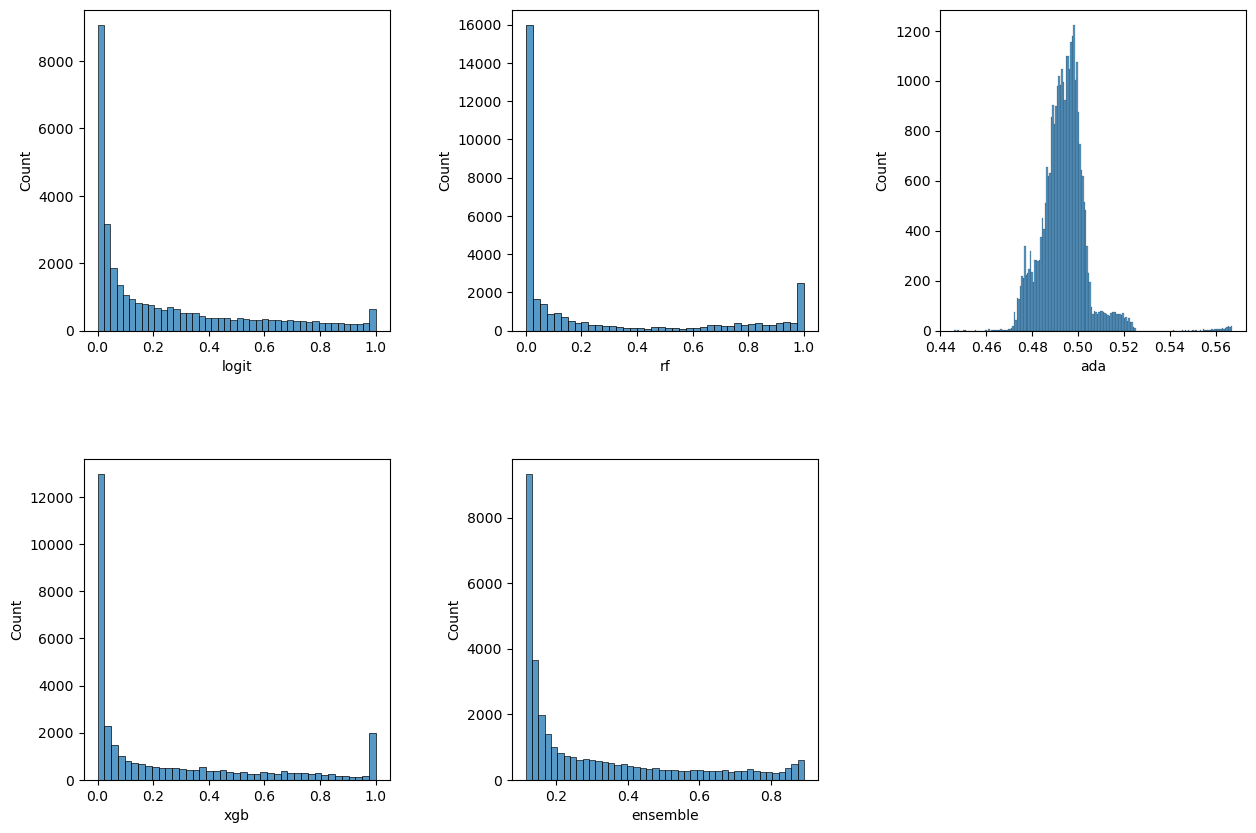

In [30]:
# visualize distributions
# ----------
# set figure parameters
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# logit
ax = fig.add_subplot(2, 3, 1)
sns.histplot(probs_df, x="logit", ax=ax)

# random forest
ax = fig.add_subplot(2, 3, 2)
sns.histplot(probs_df, x="rf", ax=ax)

# adaptive boosting
ax = fig.add_subplot(2, 3, 3)
sns.histplot(probs_df, x="ada", ax=ax)

# xgboost
ax = fig.add_subplot(2, 3, 4)
sns.histplot(probs_df, x="xgb", ax=ax)

# ensemble
ax = fig.add_subplot(2, 3, 5)
sns.histplot(probs_df, x="ensemble", ax=ax)

# show plot 
plt.show()


**QUESTION**: Do you notice something about the distribution of the predicted probabilities? Can you explain the output of `AdaboostClassifier`?

**ANSWER**: The logistic regression, random forest, and XGB models are somewhat bimodal and skew heavily right. The AdaBoost model on the other hand is centered around .47 or so. These distributions make sense because AdaBoost iteratively trains on edge cases, meaning the cases where the predicted probability could be on either side of 0.5. The ensemble tried to blend these various models together.

---
Authored by Aniket Kesari. Minor edits by Tom van Nuenen 2022. Notation and note about XGBoost added by Kasey Zapatka in Fall 2023.